## Importing and Preprocessing

In [8]:
import warnings
warnings.filterwarnings('ignore')

In [617]:
import matplotlib.pyplot as plt
import spacy
import pandas as pd
from gensim.corpora import Dictionary
from gensim.models.wrappers import LdaMallet
import os
from wordcloud import WordCloud
from tqdm import tqdm_notebook
import gensim
import pyLDAvis
import pyLDAvis.gensim
import seaborn as sns
import numpy as np
from gensim.models.coherencemodel import CoherenceModel
import requests
from PIL import Image
from io import BytesIO

In [4]:
from google.colab import drive
drive.mount('/content/drive')
DATA_PATH = '/content/drive/MyDrive'
infile = open(DATA_PATH+'/full_labeled.csv')
df = pd.read_csv(infile)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
df = pd.read_csv('/Users/jaspervogelzang/downloads/full_labeled.csv')
df = df[['week', 'tweet', 'label']]

In [10]:
df.tweet = df.tweet.astype('str')

In [11]:
df.groupby('label').size()

label
neutral       109724
sceptic        57287
supportive     34017
dtype: int64

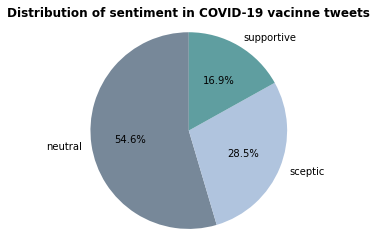

In [12]:
neutral = 109724
sceptic = 57287
supportive = 34017

labels = 'neutral', 'sceptic', 'supportive'
colors = ['lightslategray','lightsteelblue', 'cadetblue']
data1 = [neutral, sceptic, supportive]

fig, (ax1) = plt.subplots()

#Plot the results and add titel and labels
ax1.pie(data1, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
ax1.set_title('Distribution of sentiment in COVID-19 vacinne tweets', fontweight='bold')
ax1.axis('equal')  

plt.show()

In [13]:
anti = df.loc[df['label'] == 'sceptic']
pro = df.loc[df['label'] == 'supportive']
anti_pro = df.loc[df['label'] != 'neutral']

# Anti or Pro

In [14]:
nlp = spacy.load("en_core_web_sm")
texts = anti_pro.tweet
processed_texts = [text for text in tqdm_notebook(nlp.pipe(texts, 
                                             disable=["ner",
                                                      "parser"]))]
anti_pro['processed_texts'] = processed_texts

In [528]:
processed_texts = anti_pro['processed_texts']
lemmatized = [[token.lemma_ for token in text 
               if token.pos_ == 'NOUN'or 
               token.pos_ == 'ADJ' or
               token.pos_ == 'VERB'
               if not token.is_punct
               and not token.is_stop] 
              for text in processed_texts]
anti_pro['lemmatized'] = lemmatized

MIN_DF = 3 # minium document frequency
MAX_DF = 0.5 # maximum document frequency

dictionary = Dictionary(lemmatized) # get the vocabulary
dictionary.filter_extremes(no_below=MIN_DF, no_above=MAX_DF)
corpus = [dictionary.doc2bow(text) for text in lemmatized]

In [529]:
#Measuring the optimal number of topics through coherence measure
PATH_TO_MALLET = '/Users/jaspervogelzang/mallet-2.0.8/bin/mallet'

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaMallet(PATH_TO_MALLET, corpus=corpus, id2word=dictionary, num_topics=num_topics)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return coherence_values
coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=lemmatized, start=4, limit=30, step=2)

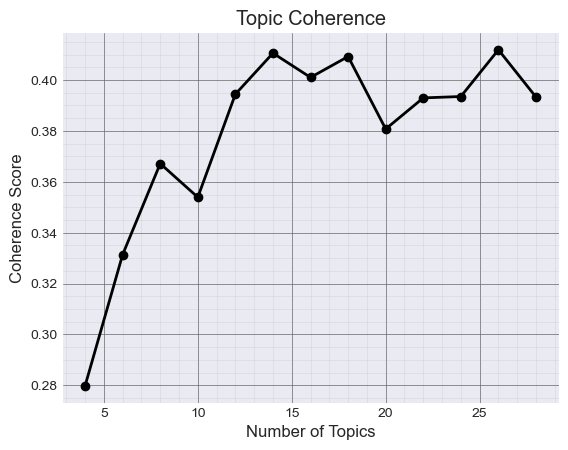

In [532]:
# Show graph for MAX_DF = 0.3
limit=30; start=4; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values, marker='o', color='black', linewidth=2)
plt.title('Topic Coherence')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.savefig('coherence_score50.png', format='png', dpi=1200)
plt.show()

In [101]:
PATH_TO_MALLET = '/Users/jaspervogelzang/mallet-2.0.8/bin/mallet'

N_TOPICS = 15
N_ITERATIONS = 1000

lda_anti_pro = LdaMallet(PATH_TO_MALLET,
                     corpus=corpus,
                     id2word=dictionary,
                     num_topics=N_TOPICS,
                     iterations=N_ITERATIONS)

In [102]:
pyLDAvis.enable_notebook()
lda_anti_pro = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(lda_anti_pro)
pyLDAvis.gensim.prepare(lda_anti_pro, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
1      0.299666  0.041719       1        1  6.754946
10     0.047339 -0.171732       2        1  6.716952
0     -0.023675 -0.119155       3        1  6.710614
6     -0.135320  0.022002       4        1  6.688482
7     -0.083946  0.215518       5        1  6.676252
4      0.067957  0.109452       6        1  6.674445
13    -0.005754  0.005073       7        1  6.666506
2     -0.070969 -0.136609       8        1  6.659185
12     0.303108  0.077780       9        1  6.650450
8      0.051710 -0.019119      10        1  6.640026
3     -0.091589  0.174190      11        1  6.639596
9     -0.031569 -0.240621      12        1  6.639355
14    -0.064469 -0.149806      13        1  6.636095
5     -0.148027  0.155442      14        1  6.632641
11    -0.114462  0.035865      15        1  6.614456, topic_info=           Term          Freq         Total Category  logprob  loglift
9        people  12694.000000  12694.000000  Default  30.0000  30.0000
429         flu  10436.000000  10436.000000  Default  29.0000  29.0000
68         year   7944.000000   7944.000000  Default  28.0000  28.0000
182       trial   7236.000000   7236.000000  Default  27.0000  27.0000
158        test   4738.000000   4738.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
26         hope   1620.118942   3716.373339  Topic15  -3.5048   1.8857
491       today    882.522973   1432.507133  Topic15  -4.1122   2.2315
1226  potential    613.877796    872.930270  Topic15  -4.4752   2.3639
534        drop    452.455036    552.356722  Topic15  -4.7803   2.5164
562         run    463.059450    792.431595  Topic15  -4.7572   2.1787

[1103 rows x 6 columns], token_table=       Topic      Freq               Term
term                                     
6204       7  1.004731                 10
6540       9  1.012131            18month
662       10  0.001878                1st
662       15  0.997070                1st
6886       9  1.012131                 2x
...      ...       ...                ...
5604       6  1.000750  ü§∑üèæ‚äç‚ôçô∏è
8634       2  1.108512       üëåüëñüëå
3042      13  1.017581                üí
10245      9  0.867541           üôèüôè
4946      12  0.991373               üôñ

[1415 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 11, 1, 7, 8, 5, 14, 3, 13, 9, 4, 10, 15, 6, 12])

In [469]:
transformed_docs = lda_anti_pro.get_document_topics(corpus)
topic_distributions = pd.DataFrame([[x[1] for x in doc] for doc in transformed_docs], 
             columns=['topic_{}'.format(i) for i in range(N_TOPICS)])

In [470]:
joined_topic_dist = anti_pro.reset_index().join(topic_distributions)
grouped_by_label = joined_topic_dist.groupby('label').mean()
data = grouped_by_label
del data['index']

In [471]:
topics={'topic_11': 'Global News', 
        'topic_3': 'Anticipation', 
        'topic_10': 'Safe trial', 
        'topic_4': 'Mandatory vaccination', 
        'topic_6': 'Science',
        'topic_9' : 'Trump administration',
        'topic_2' : 'Side effects',
        'topic_13' : 'Experimental uncertainty',
        'topic_1' : 'Risk, effectiveness, immunity',
        'topic_8' : 'Conspiracy',
        'topic_0' : 'Free available',
        'topic_5' : 'Drug',
        'topic_7' : 'Public Health',
        'topic_12' : 'Yearly flu season',
        'topic_14' : 'Discussion with experts'}

In [482]:
data = data.rename(columns = topics)
topic_distributions = topic_distributions.rename(columns = topics)

In [484]:
data_transposed = data.transpose()
data_transposed['delta'] = data_transposed['sceptic'] - data_transposed['supportive']

In [636]:
top5_supportive = data_transposed.sort_values(by=['delta'], ascending=True)[:5]
top5_sceptic = data_transposed.sort_values(by=['delta'], ascending=False)[:5]

In [637]:
top5_supportive

label                   sceptic  supportive     delta
Global News            0.064762    0.069737 -0.004974
Anticipation           0.065206    0.069397 -0.004192
Safe trial             0.066051    0.068588 -0.002537
Mandatory vaccination  0.065971    0.067933 -0.001962
Science                0.066424    0.067170 -0.000746

In [487]:
top5_sceptic

label                           sceptic  supportive     delta
Trump administration           0.068556    0.063937  0.004619
Side effects                   0.067275    0.065317  0.001958
Experimental uncertainty       0.067317    0.065398  0.001919
Risk, effectiveness, immunity  0.067392    0.065520  0.001872
Conspiracy                     0.067331    0.065751  0.001580

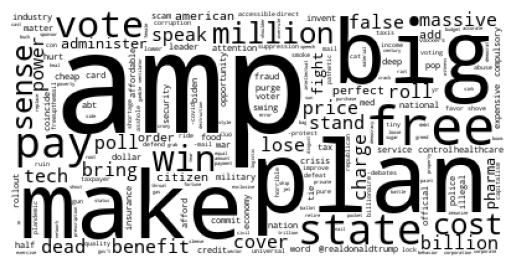

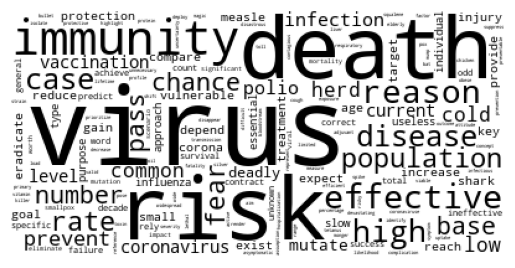

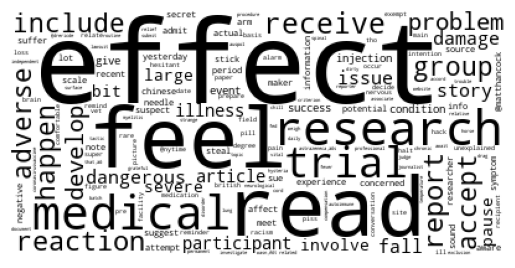

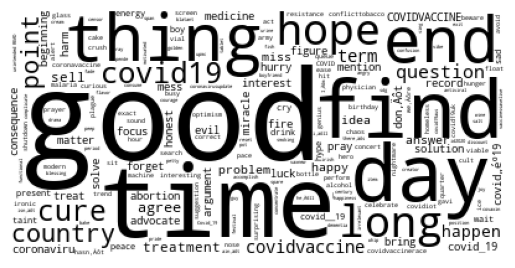

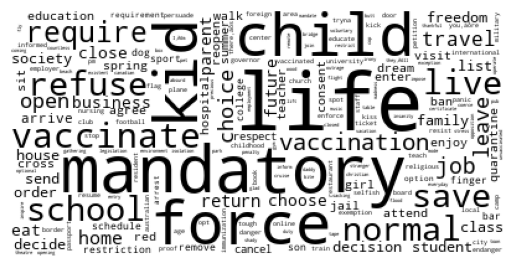

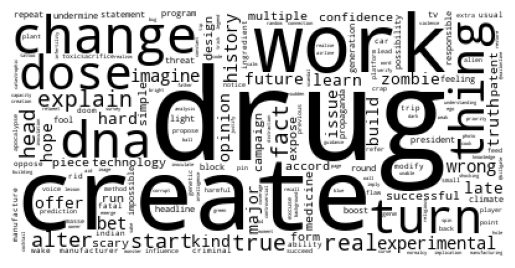

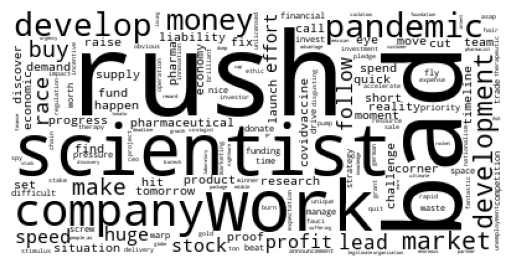

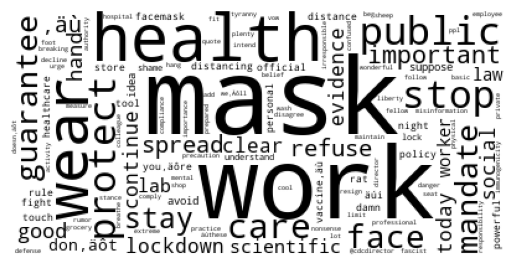

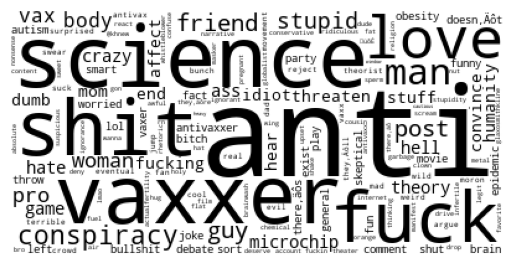

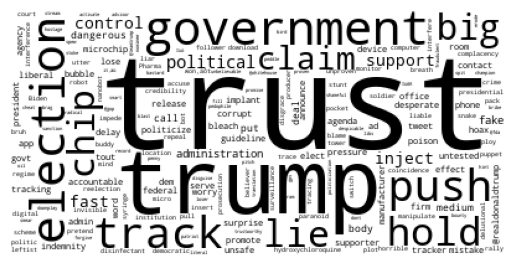

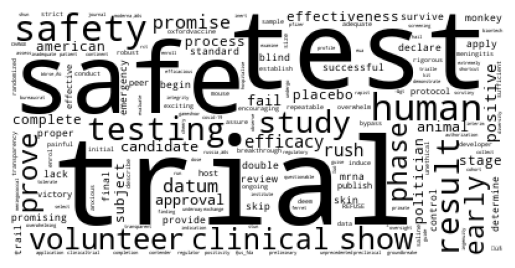

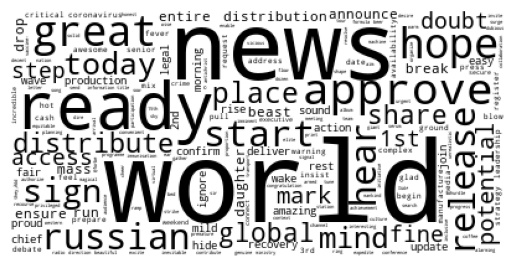

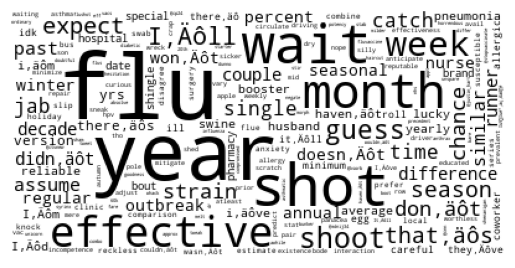

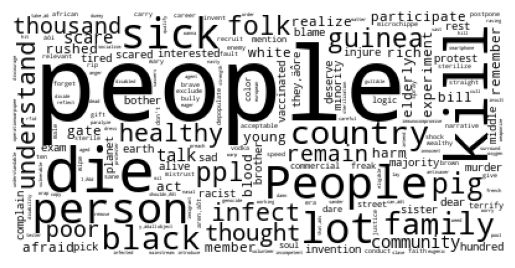

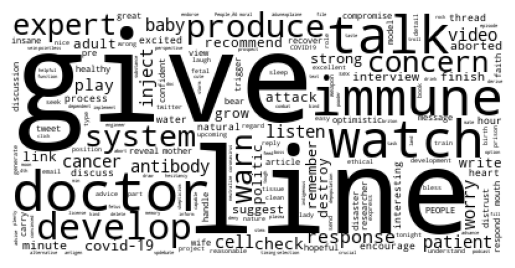

In [635]:
def grey_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(230,100%%, %d%%)" % np.random.randint(49,51))

for t in range(lda_anti_pro.num_topics):
    plt.figure()
    plt.imshow(WordCloud(color_func = lambda *args, **kwargs: "black", background_color='white').fit_words(dict(lda_anti_pro.show_topic(t, 200))))
    plt.axis("off")
    plt.savefig('2Topic #' + str(t) + '.png', format='png', dpi=1200)
    plt.show()

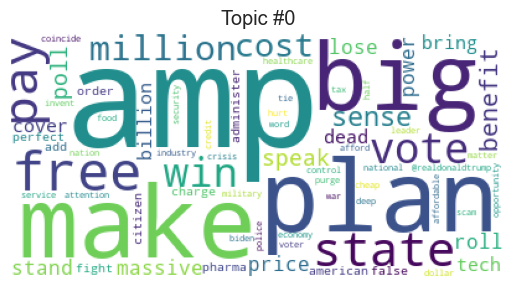

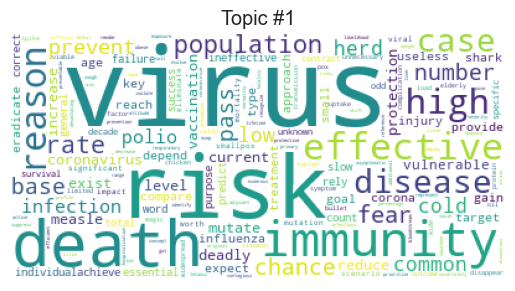

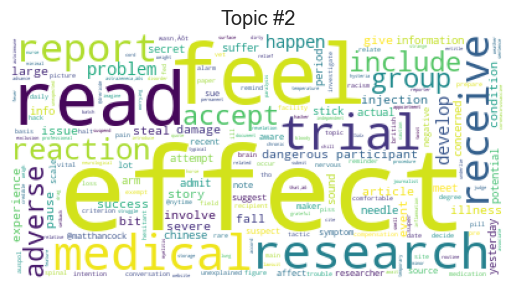

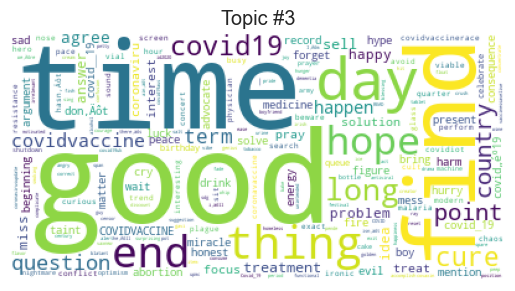

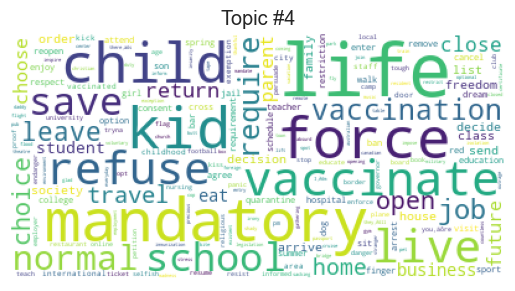

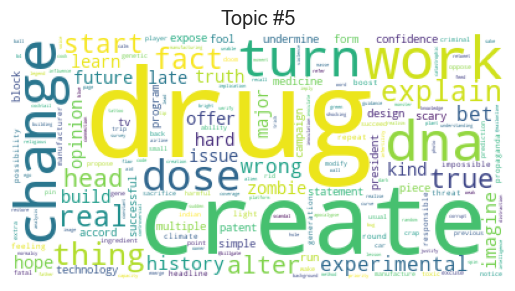

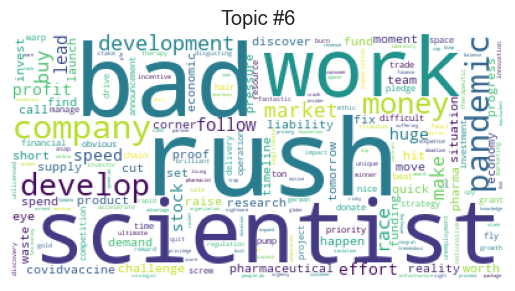

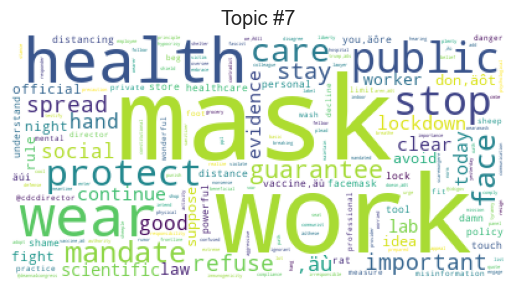

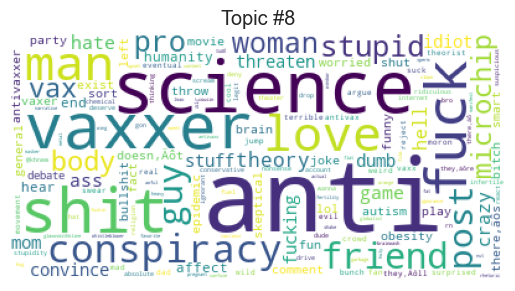

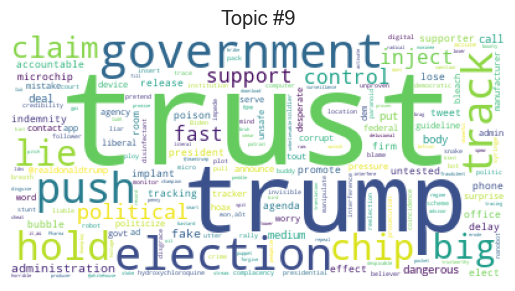

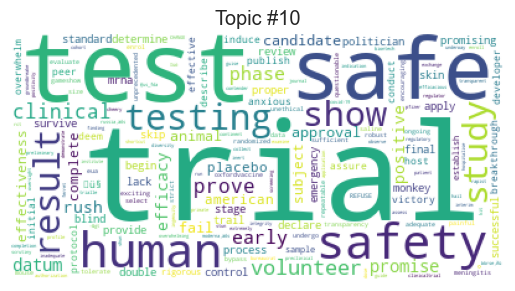

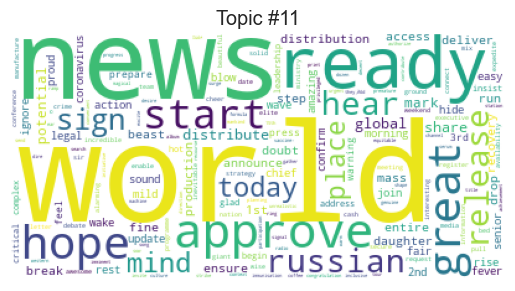

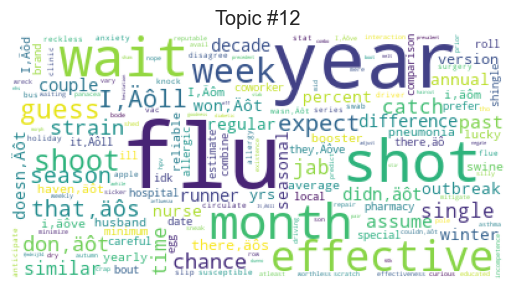

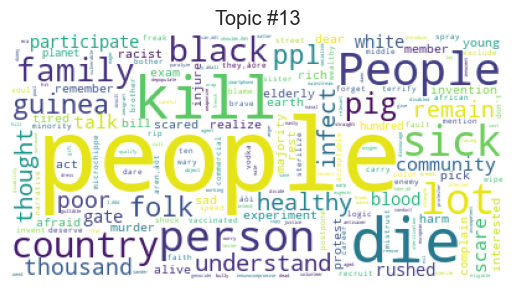

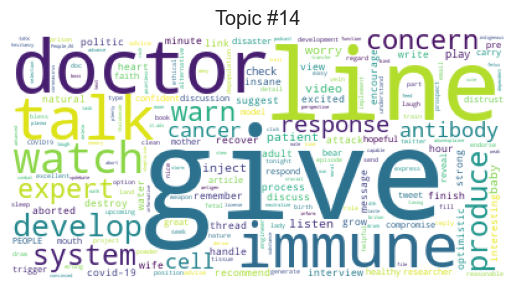

In [488]:
for t in range(lda_anti_pro.num_topics):
    plt.figure()
    plt.imshow(WordCloud(background_color='white').fit_words(dict(lda_anti_pro.show_topic(t, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.savefig('Topic #' + str(t) + '.png', format='png', dpi=1200)
    plt.show()

In [496]:
for i in topic_distributions.columns:
    row = topic_distributions[i].argmax()
    print('Most prominent tweet for topic:',i)
    print(anti_pro.iloc[row, 1], '\n')

Most prominent tweet for topic: Free available
@SenSchumer @MalcolmNance #FreeUpTheMail  National polls are a false sense of security. Swing states are a tie. Why Trump will win! -covid vaccine by Oct. Trump will take credit. -protests now hurting Biden &amp; the Dems -mail-in (&amp; all) suppression. -debates benefit Trump, even if Biden is perfect.  https://t.co/2iCyEyrCdn 

Most prominent tweet for topic: Risk, effectiveness, immunity
@guardian Britain's choice of Covid vaccine uses a saponin-based adjuvant, shown to cause 'hypoglycaemia' (glucose deficiency in the bloodstream) and to 'impair the digestion of protein and the uptake of vitamins and minerals in the gut.'  https://t.co/O9dgjuxFOT 

Most prominent tweet for topic: Side effects
@TomFlowers Which of these side effects are you willing to endure for the covid vaccine?  A) Fever and acute fainting spells. B) Fever and chronic kidney damage. C) Daily fever for 6 months. D) Fever and acute bruising on extremities. E) Fever and

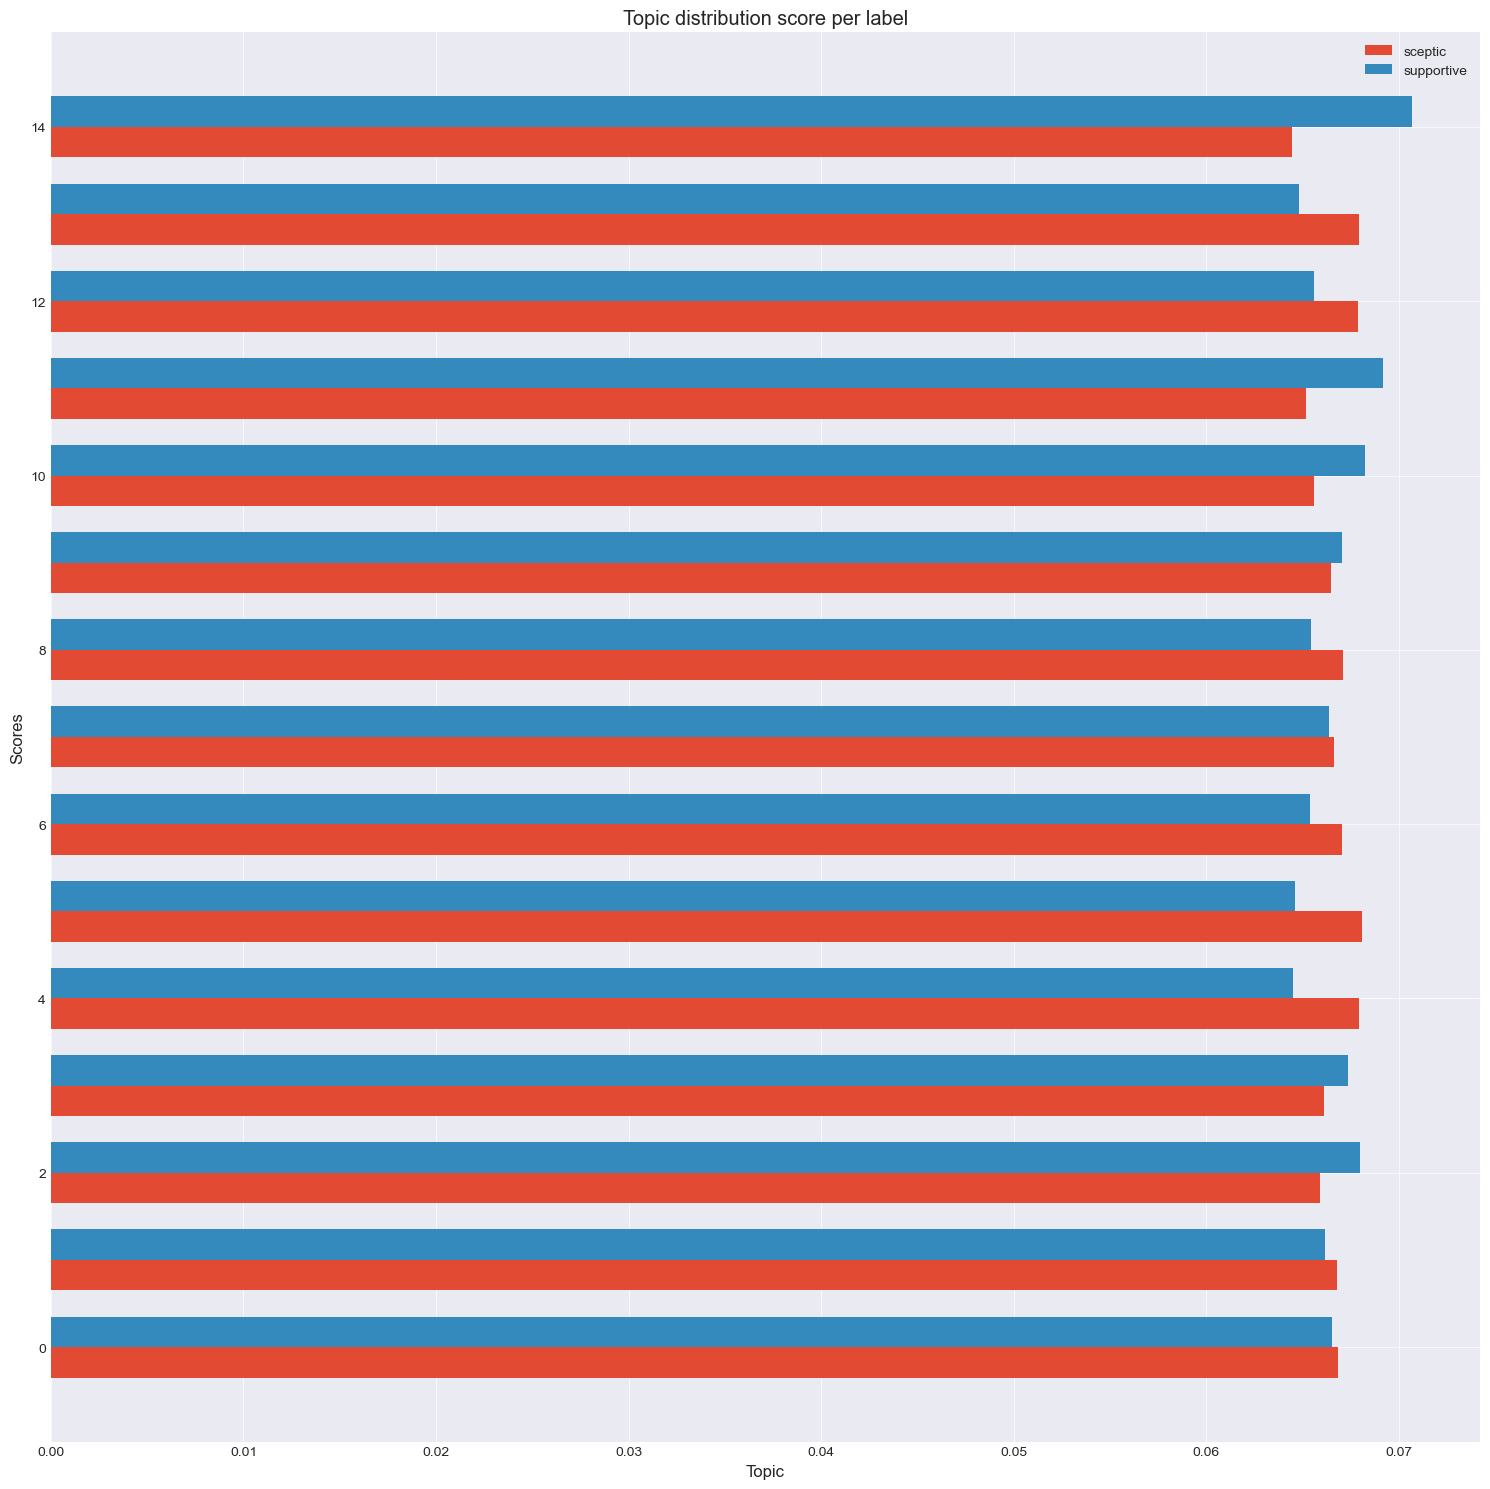

In [497]:
sceptic = data_sub.iloc[0]
supportive = data_sub.iloc[1]
labels = data_sub.columns

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(15,15))
rects1 = ax.barh(x - width/2, sceptic, width, label='sceptic')
rects2 = ax.barh(x + width/2, supportive, width, label='supportive')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_xlabel('Topic')
ax.set_title('Topic distribution score per label')
ax.legend(loc='upper right', bbox_to_anchor=(1, 1))

fig.tight_layout()

plt.show()

# Supportive tweets analysis

In [498]:
supportive_best = []
for i in top5_supportive.index:
    supportive_best.append(i)

In [500]:
joined_topic_dist = joined_topic_dist.rename(columns=topics)

In [565]:
df = joined_topic_dist
df = df.loc[df['label'] == 'supportive']
df = df.groupby(['week']).mean()
del df['index']
supportive_week = df[supportive_best]

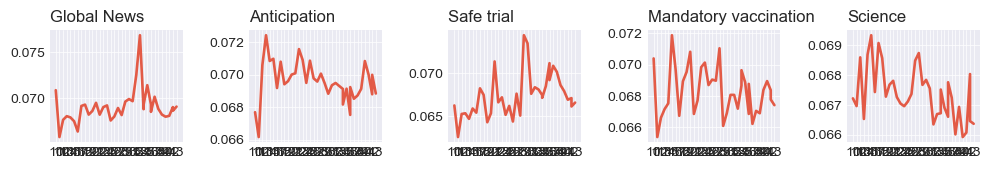

In [567]:
supportive_week.reset_index(inplace=True)
supportive_week['week'] = supportive_week['week'].astype(str)
supportive_week = supportive_week.sort_values('week')
supportive_week = supportive_week.iloc[:37]
del supportive_week['index']
data = supportive_week

num=0
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
for column in data.drop('week', axis=1):
    num+=1
 
    # Find the right spot on the plot
    plt.subplot(4,5, num)
    plt.subplots_adjust(wspace=.5, hspace=.5)
 
    # Plot the lineplot
    plt.plot(data['week'], data[column], marker='', linewidth=1.9, alpha=0.9, label=column)
    plt.title(column, loc='left', fontsize=12, fontweight=0)

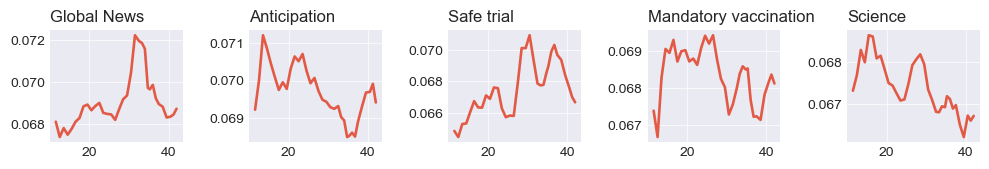

In [568]:
rolling_means = data.rolling(4).mean().dropna()
data = rolling_means
num=0
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
for column in data.drop('week', axis=1):
    num+=1
 
    # Find the right spot on the plot
    plt.subplot(4,5, num)
    plt.subplots_adjust(wspace=.5, hspace=.5)
 
    # Plot the lineplot
    plt.plot(data['week'], data[column], marker='', linewidth=1.9, alpha=0.9, label=column)
    plt.title(column, loc='left', fontsize=12, fontweight=0)
    #plt.savefig('Supportive.png', format='png', dpi=1200)

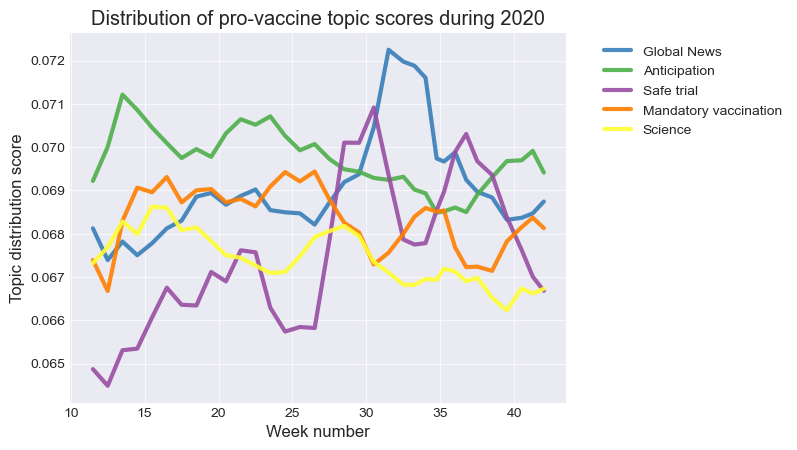

In [569]:
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')
 
# multiple line plot
num=0
for column in data.drop('week', axis=1):
    num+=1
    plt.plot(data['week'], data[column], marker='', color=palette(num), linewidth=3, alpha=0.9, label=column)
# Add legend
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xlabel('Week number')
plt.ylabel('Topic distribution score')
plt.title('Distribution of pro-vaccine topic scores during 2020')
plt.savefig('topic_scores_pro_vaccine.png', format='png', dpi=1200)

# Sceptic tweets analysis

In [555]:
sceptic_best = []
for i in top5_sceptic.index:
    sceptic_best.append(i)

In [556]:
df = joined_topic_dist
df = df.loc[df['label'] == 'sceptic']
df = df.groupby(['week']).mean()
del df['index']
sceptic_week = df[sceptic_best]

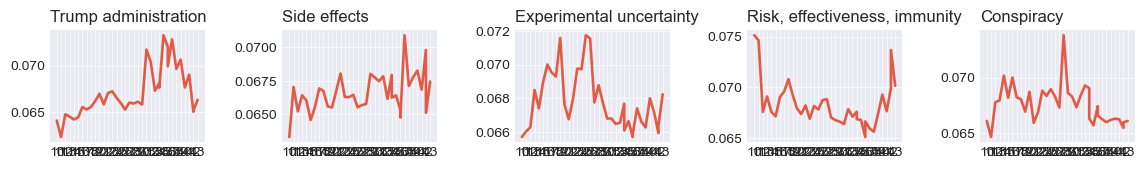

In [558]:
sceptic_week.reset_index(inplace=True)
sceptic_week['week'] = sceptic_week['week'].astype(str)
sceptic_week = sceptic_week.sort_values('week')
sceptic_week = sceptic_week.iloc[:37]
del sceptic_week['index']
data = sceptic_week

num=0
fig=plt.figure(figsize=(14,8), dpi= 100, facecolor='w', edgecolor='k')
for column in data.drop('week', axis=1):
    num+=1
 
    # Find the right spot on the plot
    plt.subplot(4,5, num)
    plt.subplots_adjust(wspace=.5, hspace=.5)
 
    # Plot the lineplot
    plt.plot(data['week'], data[column], marker='', linewidth=1.9, alpha=0.9, label=column)
    plt.title(column, loc='left', fontsize=12, fontweight=0)

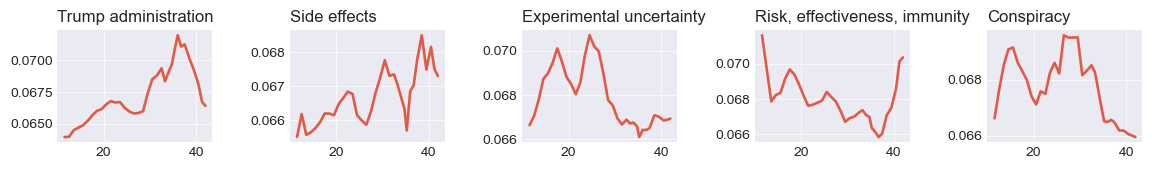

In [543]:
rolling_means = data.rolling(4).mean().dropna()
data = rolling_means
num=0
fig=plt.figure(figsize=(14,8), dpi= 100, facecolor='w', edgecolor='k')
for column in data.drop('week', axis=1):
    num+=1
 
    # Find the right spot on the plot
    plt.subplot(4,5, num)
    plt.subplots_adjust(wspace=.5, hspace=.5)
 
    # Plot the lineplot
    plt.plot(data['week'], data[column], marker='', linewidth=1.9, alpha=0.9, label=column)
    plt.title(column, loc='left', fontsize=12, fontweight=0)
    #plt.savefig('Anti_vaccine.png', format='png', dpi=1200)

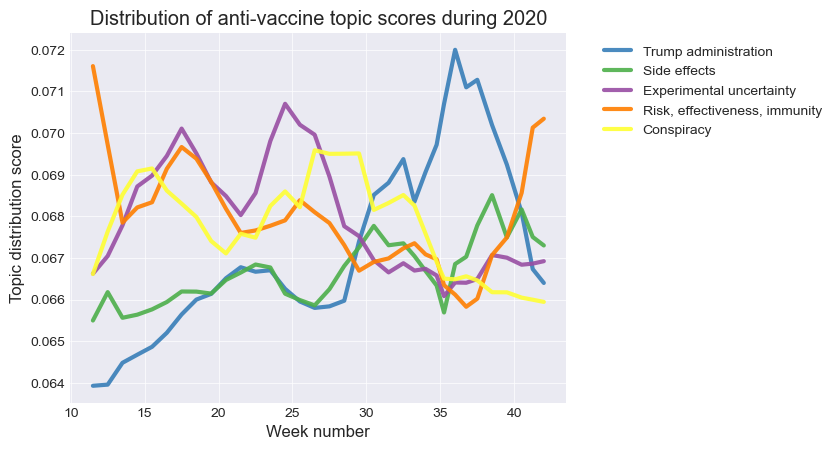

In [554]:
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')
 
# multiple line plot
num=0
for column in data.drop('week', axis=1):
    num+=1
    plt.plot(data['week'], data[column], marker='', color=palette(num), linewidth=3, alpha=0.9, label=column)
# Add legend
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xlabel('Week number')
plt.ylabel('Topic distribution score')
plt.title('Distribution of anti-vaccine topic scores during 2020')
plt.savefig('topic_scores_anti_vaccine.png', format='png', dpi=1200)

# Sceptic vs. Supportive

In [513]:
df = joined_topic_dist
df = df.loc[df['label'] == 'supportive']
df_support = df.groupby(['week']).mean()
del df_support['index']

df = joined_topic_dist
df = df.loc[df['label'] == 'sceptic']
df_sceptic = df.groupby(['week']).mean()
del df_sceptic['index']

versus = df_support - df_sceptic

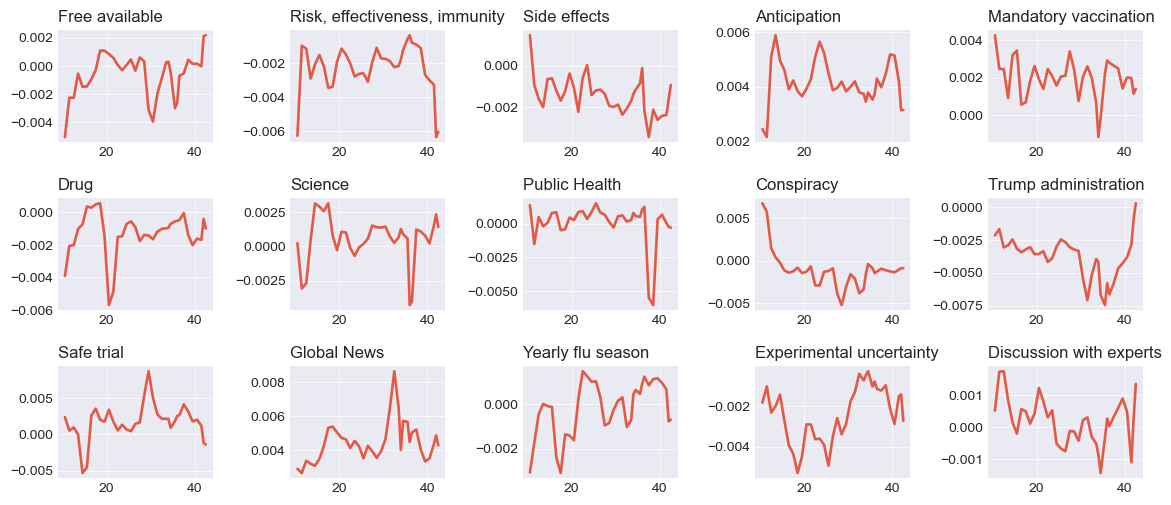

In [534]:
versus.reset_index(inplace=True)
versus['week'] = versus['week'].astype(str)
versus = versus.sort_values('week')
versus = versus.iloc[:37]
del versus['index']
data = versus

rolling_means = data.rolling(2).mean().dropna()
data = rolling_means

num=0
fig=plt.figure(figsize=(14,8), dpi= 100, facecolor='w', edgecolor='k')
for column in data.drop('week', axis=1):
    num+=1
 
    # Find the right spot on the plot
    plt.subplot(4,5, num)
    plt.subplots_adjust(wspace=.5, hspace=.5)
 
    # Plot the lineplot
    plt.plot(data['week'], data[column], marker='', linewidth=1.9, alpha=0.9, label=column)
    plt.title(column, loc='left', fontsize=12, fontweight=0)
    plt.savefig('delta.png', format='png', dpi=1200)

In [608]:
anti_count = anti_pro.loc[anti_pro['label'] == 'sceptic']
pro_count = anti_pro.loc[anti_pro['label'] == 'supportive']
count_pro = pro_count.groupby('week').size()
count_anti = anti_count.groupby('week').size()
count = pd.concat([count_pro, count_anti.reindex(count_pro.index)], axis=1)
count.columns = ['Pro-vaccine', 'Anti-vaccine']
count.reset_index(inplace=True)
count['week'] = data['week'].astype(str)
count = count.dropna()

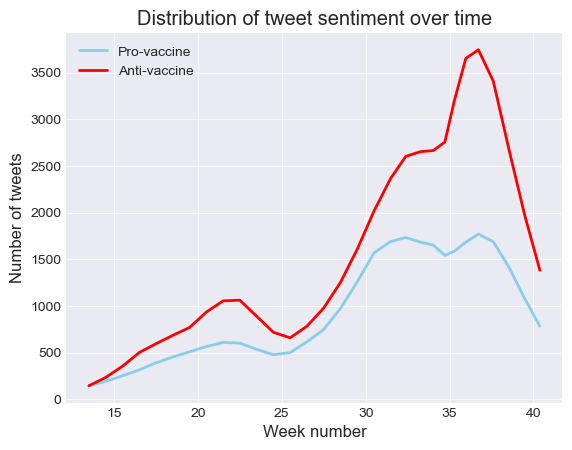

In [634]:
rolling_means = count.rolling(3).mean().dropna()
count = rolling_means
plt.plot('week', 'Pro-vaccine', data=count, color='skyblue', linewidth=2)
plt.plot('week', 'Anti-vaccine', data=count, color='red', linewidth=2)
plt.ylabel('Number of tweets')
plt.xlabel('Week number')
plt.title('Distribution of tweet sentiment over time')
plt.savefig('time.png', format='png', dpi=1200)
plt.legend()